# RadiX-Net Sparse Deep Neural Networks with Python

This notebook implements RadiX-Net sparse neural network topologies using Python with the pygraphblas library.  RadiX-Net topologies are described in the paper [RadiX-Net: Structured Sparse Matrices for DeepNeural Networks](https://arxiv.org/pdf/1905.00416.pdf) by Ryan A. Robinett and Jeremy Kepner.

In [1]:
from pygraphblas import *
from pygraphblas.gviz import draw_graph, draw_layers
from operator import mul, eq
from functools import reduce

# Permutation Matrix

The Permutation matrix used my RadiX-Net is exponentiated and accumulated into a layer in multiples of the layers place value.  Here the matrix is show being exponentiated by 3.

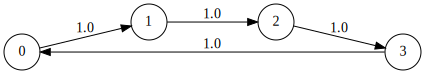

In [2]:

def permutation_matrix(size, shift=1):
    P = Matrix.sparse(FP64, size, size)    
    P[size-1,0] = 1.0
    for i in range(size-1):
        P[i,i+1] = 1.0
    return P

draw_graph(permutation_matrix(4))

The permutation matrix is exponentiated in the algorithm to cycle the connection pattern through the graph:

In [3]:
print(permutation_matrix(5)**4)

      0  1  2  3  4
  0|            1.0|  0
  1|1.0            |  1
  2|   1.0         |  2
  3|      1.0      |  3
  4|         1.0   |  4
      0  1  2  3  4


## Mixed-radix Topologies

A list of lists of integers > 1 define mixed radix topologies.  Each integer describes the number of outgoing links to be permuted from one layer to the next using the permutation matrix.  The products of the integers of each inner list must be equal, so `[[3,4],[2,3,2]]` would be valid because each inner sequence's product is `12`, but not `[[2,2,2],[2,2,3]]` since `8 != 12`.

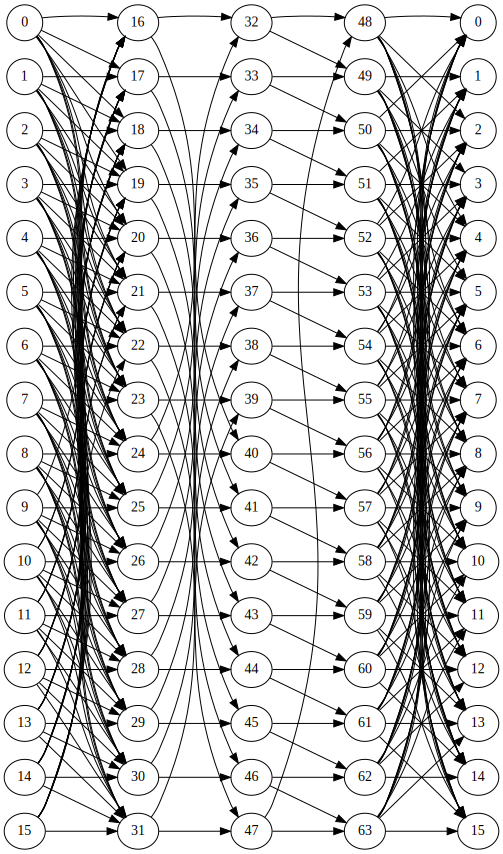

In [4]:

def mixed_topo_radix(topos):
    sizes = [reduce(mul, x) for x in topos]
    assert reduce(eq, sizes)
    size = sizes[0]
    layers = []
    P = permutation_matrix(size)
    
    for t in topos:
        place_value = 1
        for n in t:
            layer = Matrix.sparse(FP64, size, size)
            for j in range(n):
                layer += (P ** (j*place_value))
            place_value *= n
            layers.append(layer)      
    return layers

draw_layers(mixed_topo_radix([[8,2], [2,8]]))

# RadiX-Net Construction

RadiX-Nets are constructed by taking the [Kronecker Product](https://en.wikipedia.org/wiki/Kronecker_product) of a dense deep neural network with a mixed radix topology.

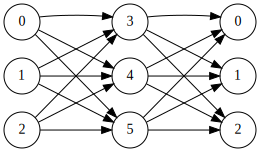

In [5]:
def ddnn(spec):
    return [Matrix.dense(FP64, spec[i], spec[i+1])
            for i in 
            range(len(spec) - 1)]

draw_layers(ddnn([3,3,3]))

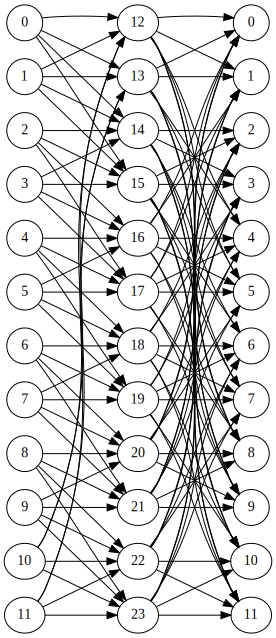

In [7]:
    
def radixnet(topos, spec):
    return [d.kronecker(w) 
            for d, w in 
            zip(mixed_topo_radix(topos), ddnn(spec))]

draw_layers(radixnet([[2,3]], [2,2,2]))                       
        